# Fruit Detection and Counting

In [10]:

import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
from torchvision.transforms.v2 import functional as F
import detection
from detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from detection.anchor_utils import AnchorGenerator
from detection.backbone_utils import resnet_fpn_backbone
from torchvision.models import ResNet34_Weights
from tqdm import tqdm
from collections import defaultdict
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset Preprocessing and Counting

In [3]:
dataset_dir = pathlib.Path("dataset")
train_images_dir = dataset_dir / "train" / "images"
train_masks_dir = dataset_dir / "train" / "masks"
test_images_dir = dataset_dir / "test" / "images"

train_image_paths = sorted(train_images_dir.iterdir())
train_mask_paths = sorted(train_masks_dir.iterdir())
test_image_paths = sorted(test_images_dir.iterdir())

In [4]:
# load the data
train_images = []
train_masks = []
test_images = []
for img_path in train_image_paths:
    train_images.append(plt.imread(img_path))
for mask_path in train_mask_paths:
    train_masks.append(plt.imread(mask_path))
for img_path in test_image_paths:
    test_images.append(plt.imread(img_path))
    
train_images = np.array(train_images)
train_masks = np.array(train_masks)
test_images = np.array(test_images)

In [5]:
num_train_images = len(train_images)
train_images.shape, train_masks.shape, test_images.shape

((670, 1280, 720, 3), (670, 1280, 720), (78, 1280, 720, 3))

In [ ]:
# show the data
fig, axs = plt.subplots(2,5, figsize=(10, 8), constrained_layout=True)
for i in range(5):
    axs[0, i].imshow(train_images[i])
    axs[0, i].set_title(f"Image {i}")
    axs[0, i].axis("off")
    axs[1, i].imshow(train_masks[i], cmap="gray")
    axs[1, i].set_title(f"Mask {i}")
    axs[1, i].axis("off")
plt.suptitle("First 5 images and masks from the training set")
plt.show()

In [7]:
# function to convert segmentation masks to bounding box annotations
def masks_to_boxes(mask):
    boxes = []
    normalized_mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    for i in range(1, 255):
        mask_copy = np.zeros_like(normalized_mask)
        mask_copy[normalized_mask == i] = 255
        contours, _ = cv2.findContours(mask_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            x1, y1, x2, y2 = x, y, x+w, y+h
            boxes.append([x1, y1, x2, y2])
    return boxes

In [8]:

train_boxes = [masks_to_boxes(mask) for mask in train_masks]

In [ ]:
# show original images with overlaid bounding boxes
fig, axs = plt.subplots(1, 5, figsize=(10, 4), constrained_layout=True)
for i in range(5):
    img = train_images[i].copy()
    # print(train_boxes[i])
    for box in train_boxes[i]:
        x1, y1, x2, y2 = box
        cv2.rectangle(img, (x1,y1), (x2,y2), (0, 0, 1), 3)
    axs[i].imshow(img)
    axs[i].set_title(f"Image {i}")
    axs[i].axis("off")
    
plt.suptitle("First 5 images with bounding boxes")
plt.show()

In [ ]:
# show a plot segmentation masks converted to bounding boxes
fig, axs = plt.subplots(5, 5, figsize=(10, 15), constrained_layout=True)
for i,img_idx in enumerate(range(0, num_train_images, num_train_images//5)):
    # original image
    axs[i, 0].imshow(train_images[img_idx])
    axs[i, 0].set_title(f"Image {i}")
    axs[i, 0].axis("off")
    # segmentation mask
    axs[i, 1].imshow(train_masks[img_idx], cmap="gray")
    axs[i, 1].set_title(f"Mask {i}")
    axs[i, 1].axis("off")
    # bounding boxes
    blank_img = np.zeros_like(train_masks[img_idx])
    for box in train_boxes[img_idx]:
        x1, y1, x2, y2 = box
        cv2.rectangle(blank_img, (x1, y1), (x2, y2), 255, 3)
    axs[i, 2].imshow(blank_img, cmap="gray")
    axs[i, 2].set_title(f"Boxes {i}")
    axs[i, 2].axis("off")
    # overlay of mask and boxes
    overlay = train_masks[img_idx].copy()
    for box in train_boxes[img_idx]:
        x1, y1, x2, y2 = box
        cv2.rectangle(overlay, (x1, y1), (x2, y2), 1, 3)
    axs[i, 3].imshow(overlay, cmap="gray")
    axs[i, 3].set_title(f"Mask Overlay {i}")
    axs[i, 3].axis("off")
    # overlay of image and boxes
    img = train_images[img_idx].copy()
    for box in train_boxes[img_idx]:
        x1, y1, x2, y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 1), 3)
    axs[i, 4].imshow(img)
    axs[i, 4].set_title(f"Image Overlay {i}")
    axs[i, 4].axis("off")
    
plt.suptitle("Images, masks, bounding boxes, and overlays")
plt.show()

In [11]:
# save train_images, train_boxes and test_images
os.makedirs("dataset/processed", exist_ok=True)
np.save("dataset/processed/train_images.npy", train_images)
np.save("dataset/processed/train_masks.npy", train_masks)
np.save("dataset/processed/test_images.npy", test_images)

with open("dataset/processed/train_boxes.npy", "wb") as f:
    for arr in train_boxes:
        np.save(f, arr, allow_pickle=False)

## Dataset and Model Implementation

### Dataset

In [3]:
train_images = np.load("dataset/processed/train_images.npy")
train_masks = np.load("dataset/processed/train_masks.npy")
train_boxes = []
with open("dataset/processed/train_boxes.npy", "rb") as f:
    while True:
        try:
            train_boxes.append(np.load(f, allow_pickle=False))
        except EOFError:
            break
test_images = np.load("dataset/processed/test_images.npy")
val_indices = np.random.choice(range(len(train_images)), size=70, replace=False)
val_images = train_images[val_indices]
val_boxes = [train_boxes[i] for i in val_indices]
train_images = np.delete(train_images, val_indices, axis=0)
train_masks = np.delete(train_masks, val_indices, axis=0)
train_boxes = [train_boxes[i] for i in range(len(train_boxes)) if i not in val_indices]

# remove samples from val which have no boxes
val_indices = []
for i, boxes in enumerate(val_boxes):
    if len(boxes) == 0:
        val_indices.append(i)
val_images = np.delete(val_images, val_indices, axis=0)
val_boxes = [val_boxes[i] for i in range(len(val_boxes)) if i not in val_indices]


In [4]:
def masks_to_boxes(mask):
    boxes = []
    normalized_mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    for i in range(1, 255):
        mask_copy = np.zeros_like(normalized_mask)
        mask_copy[normalized_mask == i] = 255
        contours, _ = cv2.findContours(mask_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            x1, y1, x2, y2 = x, y, x+w, y+h
            boxes.append([x1, y1, x2, y2])
    return boxes

In [5]:
# dataset class
class FruitDetectionDataset(Dataset):
    def __init__(self, images, boxes=None, masks = None, transform=True):
        self.images = images
        self.boxes = boxes
        self.masks = masks
        if transform:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomRotation(10),
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomVerticalFlip(0.5),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                transforms.ToTensor()
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor()
            ])
            
        classes = ["background", "fruit"]
        self.label2idx = {classes[i]: i for i in range(len(classes))}
        self.idx2label = {i: classes[i] for i in range(len(classes))}
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
            
        if self.boxes is not None and idx < len(self.boxes):
            boxes = torch.tensor(self.boxes[idx], dtype=torch.float32)
            if self.masks is not None:
                mask = self.masks[idx]
                transformed = self.transform({"image": image, "mask": mask})
                image, mask = transformed["image"], transformed["mask"]
                boxes = torch.tensor(masks_to_boxes(np.array(mask[0])), dtype=torch.float32)
            if boxes.numel() > 0:
                labels = torch.ones((boxes.shape[0],), dtype=torch.int64)  # All boxes are "fruit"
            else:
                boxes = torch.empty((0, 4))  # No boxes
                labels = torch.empty((0,), dtype=torch.int64)  # No labels
        else:
            boxes = torch.empty((0, 4))  # No boxes
            labels = torch.empty((0,), dtype=torch.int64)  # No labels
        
        if self.masks is None:
            image = self.transform(image)
        return image, {'boxes': boxes, 'labels': labels}
    
# create the dataset
train_dataset = FruitDetectionDataset(train_images, train_boxes, masks=train_masks, transform=False)
val_dataset = FruitDetectionDataset(val_images, val_boxes, transform=False)
test_dataset = FruitDetectionDataset(test_images, transform=False)

/home/gaurav/miniconda3/envs/cv/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:
def collate_function(data):
    return tuple(zip(*data))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_function)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Model

In [13]:
def get_faster_rcnn_model(fg_thresh=0.7, bg_thresh=0.3):
    backbone = resnet_fpn_backbone(
        backbone_name="resnet34", weights=ResNet34_Weights.IMAGENET1K_V1
    )
    anchor_generator = AnchorGenerator(
        sizes=((8,), (16,), (32,), (64,), (128,)),
        aspect_ratios=((0.8, 1.0, 1.2),) * 5,
    )
    model = FasterRCNN(
        backbone=backbone,
        rpn_anchor_generator=anchor_generator,
        rpn_fg_iou_thresh=fg_thresh,
        rpn_bg_iou_thresh=bg_thresh,
        num_classes=2
    )
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
    model.to(device)
    return model

model = get_faster_rcnn_model()

No changes made to the codebase from q1. The model loading step involves-
- Loading the ResNet34 backbone using the `resnet_fpn_backbone` function which loads the pretrained ResNet34 model along with the Feature Pyramid Network (FPN) on top of it.
- The anchor boxes are generated using the `AnchorGenerator` class which generates a set of anchor boxes for each feature map. The aspect ratios and scales for the anchor boxes are defined in the `anchor_sizes` and `aspect_ratios` lists. Scales of 8,16,32,64,128 and aspect ratios of 0.8, 1.0, 1.2 are used as the fruits are very small are almost spherical in shape.


Architecture diagram with what was modified in the q1 codebase:
![](images/arch_diag.png)

### Training

In [ ]:
def train_fasterrcnn(model, train_loader, epochs=5):
    train_params = {
        "task_name": "st",
        "acc_steps": 1, 
        "num_epochs": epochs,
        "lr_steps": [4, 7],
        "lr": 0.001,
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    
    optimizer = SGD(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=train_params["lr"],
        momentum=0.9,
        weight_decay=5e-5,
    )
    # optimizer = torch.optim.Adam(model.parameters(), lr=train_params["lr"])
    scheduler = MultiStepLR(optimizer, milestones=train_params["lr_steps"], gamma=0.1)

    num_epochs = train_params["num_epochs"]
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        epoch_losses = {
            "rpn_classification": [],
            "rpn_localization": [],
            "frcnn_classification": [],
            "frcnn_localization": [],
        }

        optimizer.zero_grad()
        step_count = 0

        for images, targets in tqdm(train_loader, desc="Training"):
            images = [image.float().to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            total_loss = sum(loss for loss in loss_dict.values())

            total_loss = total_loss / train_params["acc_steps"]

            total_loss.backward()

            step_count += 1
            if step_count % train_params["acc_steps"] == 0:
                optimizer.step()
                optimizer.zero_grad()

            epoch_losses["rpn_classification"].append(
                loss_dict["loss_objectness"].item()
            )
            epoch_losses["rpn_localization"].append(
                loss_dict["loss_rpn_box_reg"].item()
            )
            epoch_losses["frcnn_classification"].append(
                loss_dict["loss_classifier"].item()
            )
            epoch_losses["frcnn_localization"].append(loss_dict["loss_box_reg"].item())

        scheduler.step()

        loss_output = " | ".join(
            f"{key}: {np.mean(values):.4f}" for key, values in epoch_losses.items()
        )
        print(loss_output)

    print("Training complete.")
    
train_fasterrcnn(model, train_loader)

Epoch 1/5


Training:   0%|          | 0/150 [00:00<?, ?it/s]/tmp/ipykernel_9415/2903762583.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  boxes = torch.tensor(masks_to_boxes(np.array(mask[0])), dtype=torch.float32)
Training: 100%|██████████| 150/150 [01:10<00:00,  2.12it/s]


rpn_classification: 0.2445 | rpn_localization: 0.0771 | frcnn_classification: 0.2292 | frcnn_localization: 0.2176
Epoch 2/5


Training: 100%|██████████| 150/150 [01:11<00:00,  2.11it/s]


rpn_classification: 0.1019 | rpn_localization: 0.0679 | frcnn_classification: 0.2152 | frcnn_localization: 0.3998
Epoch 3/5


Training: 100%|██████████| 150/150 [01:11<00:00,  2.10it/s]


rpn_classification: 0.0792 | rpn_localization: 0.0618 | frcnn_classification: 0.2003 | frcnn_localization: 0.4105
Epoch 4/5


Training: 100%|██████████| 150/150 [01:11<00:00,  2.11it/s]


rpn_classification: 0.0656 | rpn_localization: 0.0578 | frcnn_classification: 0.2075 | frcnn_localization: 0.4189
Epoch 5/5


Training: 100%|██████████| 150/150 [01:11<00:00,  2.10it/s]

rpn_classification: 0.0568 | rpn_localization: 0.0549 | frcnn_classification: 0.2016 | frcnn_localization: 0.4109
Training complete.


### Visualization

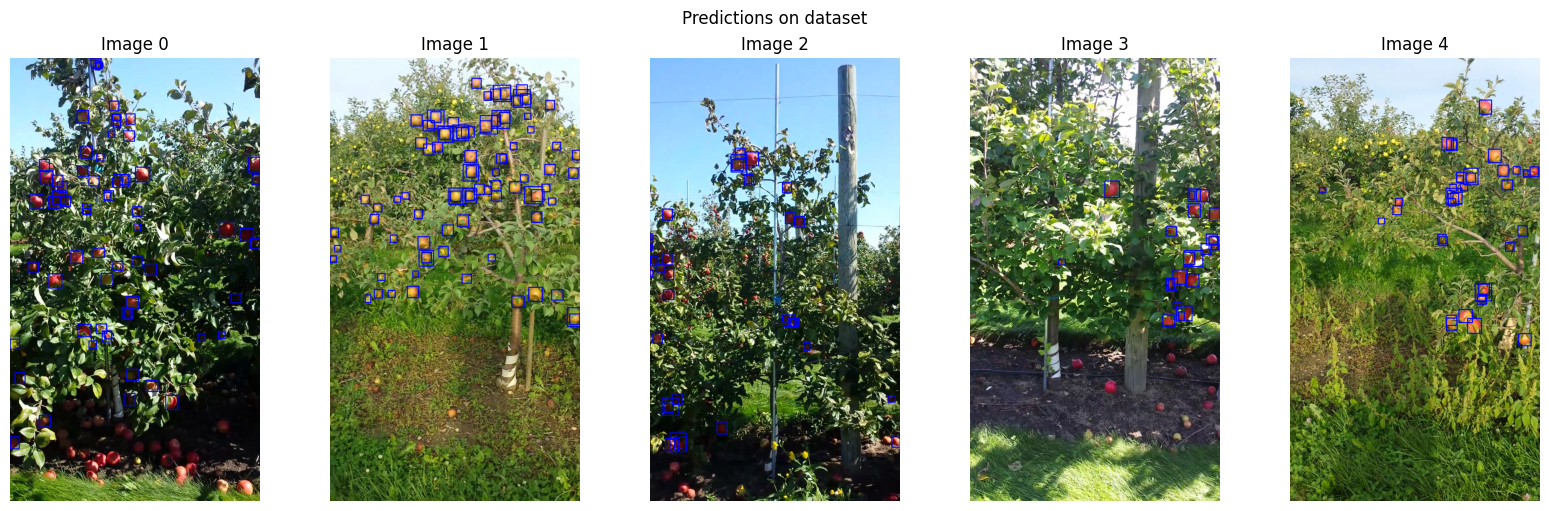

In [22]:
# visualize the predictions on the validation set
def visualize_predictions(model, val_loader):
    model.eval()
    device = next(model.parameters()).device
    fig, axs = plt.subplots(1, 5, figsize=(16, 5), constrained_layout=True)
    for i, (image, target) in enumerate(val_loader):
        if i >= 5:
            break
        image = image[0].to(device)
        target = {k: v[0].to(device) for k, v in target.items()}
        with torch.no_grad():
            prediction = model([image])[0]
        
        # print(f"Prediction {i}: {prediction}")
        # break
            
        image = image.cpu().numpy().transpose(1, 2, 0)
        image = np.clip(image, 0, 1)
        
        image = image.copy()
        for idx, box in enumerate(prediction["boxes"]):
            if prediction["scores"][idx] < 0.5:
                continue
            x1, y1, x2, y2 = box.cpu().numpy().astype(int)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 1), 2)
            
        axs[i].imshow(image)
        axs[i].set_title(f"Image {i}")
        axs[i].axis("off")

    plt.suptitle("Predictions on dataset")
    plt.show()
    
visualize_predictions(model, val_loader)


### Evaluation

100%|██████████| 69/69 [00:02<00:00, 28.31it/s]


mAP at IoU threshold 0.5: 0.6517747905374661
mAP at IoU threshold 0.7: 0.3399565376188025
mAP at IoU threshold 0.9: 0.0606060606060606
False Positives per class: {'fruit': 4120}
False Negatives per class: {'fruit': 659}


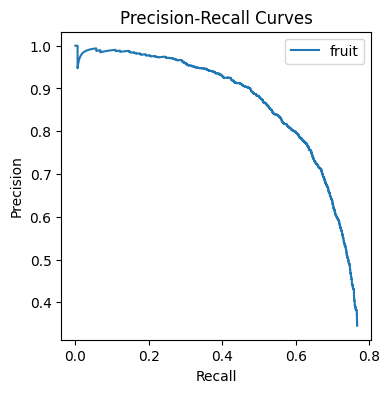

In [19]:
# reference to the infer.py and gpt
def get_iou(det, gt):
    det_x1, det_y1, det_x2, det_y2 = det
    gt_x1, gt_y1, gt_x2, gt_y2 = gt

    x_left = max(det_x1, gt_x1)
    y_top = max(det_y1, gt_y1)
    x_right = min(det_x2, gt_x2)
    y_bottom = min(det_y2, gt_y2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    area_intersection = (x_right - x_left) * (y_bottom - y_top)
    det_area = (det_x2 - det_x1) * (det_y2 - det_y1)
    gt_area = (gt_x2 - gt_x1) * (gt_y2 - gt_y1)
    area_union = float(det_area + gt_area - area_intersection + 1E-6)
    iou = area_intersection / area_union
    return iou

def compute_map(det_boxes, gt_boxes, iou_threshold=0.5, method='interp'):

    gt_labels = {cls_key for im_gt in gt_boxes for cls_key in im_gt.keys()}
    gt_labels = sorted(gt_labels)
    all_aps = {}
    # average precisions for ALL classes
    aps = []
    for idx, label in enumerate(gt_labels):
        # Get detection predictions of this class
        cls_dets = [
            [im_idx, im_dets_label] for im_idx, im_dets in enumerate(det_boxes)
            if label in im_dets for im_dets_label in im_dets[label]
        ]

        # Sort them by confidence score
        cls_dets = sorted(cls_dets, key=lambda k: -k[1][-1])

        # For tracking which gt boxes of this class have already been matched
        gt_matched = [[False for _ in im_gts[label]] for im_gts in gt_boxes]
        # Number of gt boxes for this class for recall calculation
        num_gts = sum([len(im_gts[label]) for im_gts in gt_boxes])
        tp = [0] * len(cls_dets)
        fp = [0] * len(cls_dets)

        # For each prediction
        for det_idx, (im_idx, det_pred) in enumerate(cls_dets):
            # Get gt boxes for this image and this label
            im_gts = gt_boxes[im_idx][label]
            max_iou_found = -1
            max_iou_gt_idx = -1

            # Get best matching gt box
            for gt_box_idx, gt_box in enumerate(im_gts):
                gt_box_iou = get_iou(det_pred[:-1], gt_box)
                if gt_box_iou > max_iou_found:
                    max_iou_found = gt_box_iou
                    max_iou_gt_idx = gt_box_idx
            # TP only if iou >= threshold and this gt has not yet been matched
            if max_iou_found < iou_threshold or gt_matched[im_idx][max_iou_gt_idx]:
                fp[det_idx] = 1
            else:
                tp[det_idx] = 1
                # If tp then we set this gt box as matched
                gt_matched[im_idx][max_iou_gt_idx] = True
        # Cumulative tp and fp
        tp = np.cumsum(tp)
        fp = np.cumsum(fp)

        eps = np.finfo(np.float32).eps
        recalls = tp / np.maximum(num_gts, eps)
        precisions = tp / np.maximum((tp + fp), eps)

        if method == 'area':
            recalls = np.concatenate(([0.0], recalls, [1.0]))
            precisions = np.concatenate(([0.0], precisions, [0.0]))

            # Replace precision values with recall r with maximum precision value
            # of any recall value >= r
            # This computes the precision envelope
            for i in range(precisions.size - 1, 0, -1):
                precisions[i - 1] = np.maximum(precisions[i - 1], precisions[i])
            # For computing area, get points where recall changes value
            i = np.where(recalls[1:] != recalls[:-1])[0]
            # Add the rectangular areas to get ap
            ap = np.sum((recalls[i + 1] - recalls[i]) * precisions[i + 1])
        elif method == 'interp':
            ap = 0.0
            for interp_pt in np.arange(0, 1 + 1E-3, 0.1):
                # Get precision values for recall values >= interp_pt
                prec_interp_pt = precisions[recalls >= interp_pt]

                # Get max of those precision values
                prec_interp_pt = prec_interp_pt.max() if prec_interp_pt.size > 0.0 else 0.0
                ap += prec_interp_pt
            ap = ap / 11.0
        else:
            raise ValueError('Method can only be area or interp')
        if num_gts > 0:
            aps.append(ap)
            all_aps[label] = ap
        else:
            all_aps[label] = np.nan
    # compute mAP at provided iou threshold
    mean_ap = sum(aps) / len(aps)
    return mean_ap, all_aps

def evaluate_fasterrcnn(model, dataset, data_loader):
    gts, preds = [], []
    model.to(device)
    model.eval()
    for img, target in tqdm(data_loader):
        img = img.float().to(device)
        target_boxes = target['boxes'].float().to(device)[0]
        target_labels = target['labels'].to(device)[0]

        with torch.no_grad():
            frcnn_output = model(img, None)[0]
        
        boxes = frcnn_output['boxes']
        labels = frcnn_output['labels']
        scores = frcnn_output['scores']
        
        pred_boxes, gt_boxes = {}, {}
        for label_name in dataset.label2idx:
            if label_name == "background":  # Skip background class
                continue
            pred_boxes[label_name] = []
            gt_boxes[label_name] = []
            
        for idx, box in enumerate(boxes):
            x1, y1, x2, y2 = box.detach().cpu().numpy()
            label = labels[idx].detach().cpu().item()
            score = scores[idx].detach().cpu().item()
            label_name = dataset.idx2label[label]
            if label_name == "background":  # Skip background class
                continue
            pred_boxes[label_name].append([x1, y1, x2, y2, score])
            
        for idx, box in enumerate(target_boxes):
            x1, y1, x2, y2 = box.detach().cpu().numpy()
            label = target_labels[idx].detach().cpu().item()
            label_name = dataset.idx2label[label]
            if label_name == "background":  # Skip background class
                continue
            gt_boxes[label_name].append([x1, y1, x2, y2])
        
        gts.append(gt_boxes)
        preds.append(pred_boxes)
    
    # Compute mAP at different IoU thresholds
    iou_thresholds = [0.5, 0.7, 0.9]
    mAPs = []
    for iou_threshold in iou_thresholds:
        mean_ap, all_aps = compute_map(preds, gts, iou_threshold=iou_threshold)
        mAPs.append(mean_ap)
        print(f"mAP at IoU threshold {iou_threshold}: {mean_ap}")
        # print(f"AP per class: {all_aps}")
    
    # Analyze False Positives and False Negatives
    analyze_fp_fn(preds, gts)
    
    # Plot Precision-Recall curves
    plot_precision_recall_curves(preds, gts)
    

def plot_precision_recall_curves(preds, gts):
    gt_labels = {cls_key for im_gt in gts for cls_key in im_gt.keys()}
    gt_labels = sorted(gt_labels)
    
    plt.figure(figsize=(4,4))
    for label in gt_labels:
        if label == "background":  # Skip background class
            continue
        precisions, recalls = compute_precision_recall(preds, gts, label)
        plt.plot(recalls, precisions, label=label)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.show()

def compute_precision_recall(preds, gts, label, iou_threshold=0.5):
    cls_dets = [
        [im_idx, im_dets_label] for im_idx, im_dets in enumerate(preds)
        if label in im_dets for im_dets_label in im_dets[label]
    ]
    cls_dets = sorted(cls_dets, key=lambda k: -k[1][-1])
    
    gt_matched = [[False for _ in im_gts[label]] for im_gts in gts]
    num_gts = sum([len(im_gts[label]) for im_gts in gts])
    tp = [0] * len(cls_dets)
    fp = [0] * len(cls_dets)
    
    for det_idx, (im_idx, det_pred) in enumerate(cls_dets):
        im_gts = gts[im_idx][label]
        max_iou_found = -1
        max_iou_gt_idx = -1
        
        for gt_box_idx, gt_box in enumerate(im_gts):
            gt_box_iou = get_iou(det_pred[:-1], gt_box)
            if gt_box_iou > max_iou_found:
                max_iou_found = gt_box_iou
                max_iou_gt_idx = gt_box_idx
        
        if max_iou_found < iou_threshold or gt_matched[im_idx][max_iou_gt_idx]:
            fp[det_idx] = 1
        else:
            tp[det_idx] = 1
            gt_matched[im_idx][max_iou_gt_idx] = True
    
    tp = np.cumsum(tp)
    fp = np.cumsum(fp)
    
    eps = np.finfo(np.float32).eps
    recalls = tp / np.maximum(num_gts, eps)
    precisions = tp / np.maximum((tp + fp), eps)
    
    return precisions, recalls

def analyze_fp_fn(preds, gts):
    gt_labels = {cls_key for im_gt in gts for cls_key in im_gt.keys()}
    gt_labels = sorted(gt_labels)
    
    fp_counts = defaultdict(int)
    fn_counts = defaultdict(int)
    
    for label in gt_labels:
        if label == "background":  # Skip background class
            continue
        cls_dets = [
            [im_idx, im_dets_label] for im_idx, im_dets in enumerate(preds)
            if label in im_dets for im_dets_label in im_dets[label]
        ]
        cls_dets = sorted(cls_dets, key=lambda k: -k[1][-1])
        
        gt_matched = [[False for _ in im_gts[label]] for im_gts in gts]
        num_gts = sum([len(im_gts[label]) for im_gts in gts])
        
        for det_idx, (im_idx, det_pred) in enumerate(cls_dets):
            im_gts = gts[im_idx][label]
            max_iou_found = -1
            max_iou_gt_idx = -1
            
            for gt_box_idx, gt_box in enumerate(im_gts):
                gt_box_iou = get_iou(det_pred[:-1], gt_box)
                if gt_box_iou > max_iou_found:
                    max_iou_found = gt_box_iou
                    max_iou_gt_idx = gt_box_idx
            
            if max_iou_found < 0.5 or gt_matched[im_idx][max_iou_gt_idx]:
                fp_counts[label] += 1
            else:
                gt_matched[im_idx][max_iou_gt_idx] = True
        
        for im_idx, im_gts in enumerate(gts):
            if label in im_gts:
                for gt_box_idx, gt_box in enumerate(im_gts[label]):
                    if not gt_matched[im_idx][gt_box_idx]:
                        fn_counts[label] += 1
    
    print("False Positives per class:", dict(fp_counts))
    print("False Negatives per class:", dict(fn_counts))

evaluate_fasterrcnn(model, val_dataset, val_loader)

## Training and Detection Analysis

### Anchor Box Configuration

The anchor box configuration was chosen based on the size of the fruits in the dataset. The sizes and aspect ratios were chosen to cover the range of sizes and shapes of the fruits in the dataset. As visible in the visualization above, most of the true boxes are square in shape and extremely small in size. Hence, the following anchor box configuration was chosen:
- Sizes: [8, 16, 32, 64, 128]
- Aspect Ratios: [0.8, 1, 1.2]

### Role of NMS in fruit detection

NMS is used to remove redundant bounding boxes that are detected for the same object. It is used to remove duplicate detections and keep only the most confident one. In the fruit detection task, NMS is used to remove duplicate detections of the same fruit. It helps in reducing the number of false positives and improves the accuracy of the detection.

### Strategies for handling overlapping fruits

The contours function has been used to decide the bounding boxes for the fruits based on the masks. To prevent adjacent fruits from being detected as a single fruit, the following strategy has be used: 
- Since the masks of different fruits are slightly different in color in the masks, an iteration over all possible such values to create a segmented mask for bounding box detection has been used.
- This helps in creating separate bounding boxes for each fruit even if they are overlapping as long as they have different colors in the mask.

### Comparison of augmentation strategies

/home/gaurav/miniconda3/envs/cv/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Epoch 1/15


Training:   0%|          | 0/38 [00:00<?, ?it/s]/tmp/ipykernel_9415/2903762583.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  boxes = torch.tensor(masks_to_boxes(np.array(mask[0])), dtype=torch.float32)
Training: 100%|██████████| 38/38 [01:41<00:00,  2.67s/it]


rpn_classification: 0.5036 | rpn_localization: 0.0902 | frcnn_classification: 0.3161 | frcnn_localization: 0.0778
Epoch 2/15


Training: 100%|██████████| 38/38 [01:41<00:00,  2.66s/it]


rpn_classification: 0.2546 | rpn_localization: 0.0841 | frcnn_classification: 0.1868 | frcnn_localization: 0.1328
Epoch 3/15


Training: 100%|██████████| 38/38 [01:42<00:00,  2.69s/it]


rpn_classification: 0.2178 | rpn_localization: 0.0791 | frcnn_classification: 0.1309 | frcnn_localization: 0.1482
Epoch 4/15


Training: 100%|██████████| 38/38 [01:43<00:00,  2.72s/it]


rpn_classification: 0.1817 | rpn_localization: 0.0812 | frcnn_classification: 0.1753 | frcnn_localization: 0.2113
Epoch 5/15


Training: 100%|██████████| 38/38 [01:41<00:00,  2.68s/it]


rpn_classification: 0.1614 | rpn_localization: 0.0804 | frcnn_classification: 0.1945 | frcnn_localization: 0.2449
Epoch 6/15


Training: 100%|██████████| 38/38 [01:42<00:00,  2.69s/it]


rpn_classification: 0.1550 | rpn_localization: 0.0794 | frcnn_classification: 0.1966 | frcnn_localization: 0.2503
Epoch 7/15


Training: 100%|██████████| 38/38 [01:43<00:00,  2.71s/it]


rpn_classification: 0.1559 | rpn_localization: 0.0795 | frcnn_classification: 0.1983 | frcnn_localization: 0.2544
Epoch 8/15


Training: 100%|██████████| 38/38 [01:42<00:00,  2.70s/it]


rpn_classification: 0.1514 | rpn_localization: 0.0800 | frcnn_classification: 0.1962 | frcnn_localization: 0.2585
Epoch 9/15


Training: 100%|██████████| 38/38 [01:42<00:00,  2.69s/it]


rpn_classification: 0.1534 | rpn_localization: 0.0806 | frcnn_classification: 0.1973 | frcnn_localization: 0.2604
Epoch 10/15


Training: 100%|██████████| 38/38 [01:41<00:00,  2.68s/it]


rpn_classification: 0.1511 | rpn_localization: 0.0807 | frcnn_classification: 0.1963 | frcnn_localization: 0.2583
Epoch 11/15


Training: 100%|██████████| 38/38 [01:42<00:00,  2.70s/it]


rpn_classification: 0.1541 | rpn_localization: 0.0812 | frcnn_classification: 0.1975 | frcnn_localization: 0.2578
Epoch 12/15


Training: 100%|██████████| 38/38 [01:42<00:00,  2.69s/it]


rpn_classification: 0.1511 | rpn_localization: 0.0782 | frcnn_classification: 0.1955 | frcnn_localization: 0.2596
Epoch 13/15


Training: 100%|██████████| 38/38 [01:42<00:00,  2.70s/it]


rpn_classification: 0.1533 | rpn_localization: 0.0819 | frcnn_classification: 0.1974 | frcnn_localization: 0.2613
Epoch 14/15


Training: 100%|██████████| 38/38 [01:41<00:00,  2.68s/it]


rpn_classification: 0.1495 | rpn_localization: 0.0806 | frcnn_classification: 0.1968 | frcnn_localization: 0.2600
Epoch 15/15


Training: 100%|██████████| 38/38 [01:43<00:00,  2.72s/it]


rpn_classification: 0.1527 | rpn_localization: 0.0801 | frcnn_classification: 0.1966 | frcnn_localization: 0.2606
Training complete.


100%|██████████| 69/69 [00:02<00:00, 28.45it/s]


mAP at IoU threshold 0.5: 0.20106055605213474
mAP at IoU threshold 0.7: 0.022727272727272728
mAP at IoU threshold 0.9: 0.0002457002457002457
False Positives per class: {'fruit': 5644}
False Negatives per class: {'fruit': 1576}


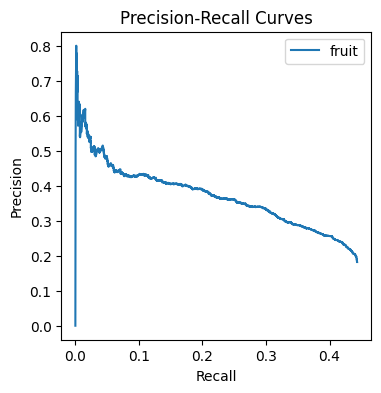

In [28]:
# augmentation training
train_dataset_aug = FruitDetectionDataset(train_images, train_boxes, train_masks, transform=True)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=16, shuffle=True, collate_fn=collate_function)
model_no_aug = get_faster_rcnn_model()
train_fasterrcnn(model_no_aug, train_loader_aug, epochs=15)
evaluate_fasterrcnn(model_no_aug, val_dataset, val_loader)

No Augmentation -

>mAP at IoU threshold 0.5: 0.6517747905374661 \
>mAP at IoU threshold 0.7: 0.3399565376188025 \
>mAP at IoU threshold 0.9: 0.0606060606060606 \
>False Positives per class: {'fruit': 4120} \
>False Negatives per class: {'fruit': 659} 

With Augmentation -
>mAP at IoU threshold 0.5: 0.20106055605213474 \
>mAP at IoU threshold 0.7: 0.022727272727272728 \
>mAP at IoU threshold 0.9: 0.0002457002457002457 \
>False Positives per class: {'fruit': 5644} \
>False Negatives per class: {'fruit': 1576} 

Augmentation strategies used:
- RandomHorizontalFlip
- RandomVerticalFlip
- RandomRotation
- ColorJitter


### Effect of Confidence (IoU) thresholds

Epoch 1/5


Training:   0%|          | 0/150 [00:00<?, ?it/s]/tmp/ipykernel_9415/2903762583.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  boxes = torch.tensor(masks_to_boxes(np.array(mask[0])), dtype=torch.float32)
Training: 100%|██████████| 150/150 [01:11<00:00,  2.11it/s]


rpn_classification: 0.3210 | rpn_localization: 0.1350 | frcnn_classification: 0.2117 | frcnn_localization: 0.1467
Epoch 2/5


Training: 100%|██████████| 150/150 [01:11<00:00,  2.10it/s]


rpn_classification: 0.1200 | rpn_localization: 0.1224 | frcnn_classification: 0.1760 | frcnn_localization: 0.3059
Epoch 3/5


Training: 100%|██████████| 150/150 [01:11<00:00,  2.09it/s]


rpn_classification: 0.0865 | rpn_localization: 0.1100 | frcnn_classification: 0.1759 | frcnn_localization: 0.3680
Epoch 4/5


Training: 100%|██████████| 150/150 [01:11<00:00,  2.10it/s]


rpn_classification: 0.0689 | rpn_localization: 0.1002 | frcnn_classification: 0.1776 | frcnn_localization: 0.3879
Epoch 5/5


Training: 100%|██████████| 150/150 [01:12<00:00,  2.08it/s]


rpn_classification: 0.0590 | rpn_localization: 0.0931 | frcnn_classification: 0.1737 | frcnn_localization: 0.3833
Training complete.


100%|██████████| 69/69 [00:02<00:00, 28.70it/s]


mAP at IoU threshold 0.5: 0.6297110275990542
mAP at IoU threshold 0.7: 0.3182202336966408
mAP at IoU threshold 0.9: 0.045454545454545456
False Positives per class: {'fruit': 4168}
False Negatives per class: {'fruit': 722}


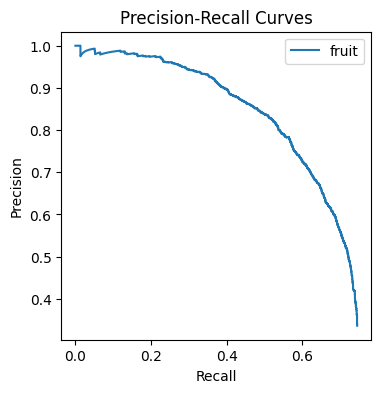

In [25]:
# low thresholds - allowing more positive and negative anchors
model_low_thresh = get_faster_rcnn_model(fg_thresh=0.5)
train_fasterrcnn(model_low_thresh, train_loader)
evaluate_fasterrcnn(model_low_thresh, val_dataset, val_loader)

Epoch 1/5


Training:   0%|          | 0/150 [00:00<?, ?it/s]/tmp/ipykernel_9415/2903762583.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  boxes = torch.tensor(masks_to_boxes(np.array(mask[0])), dtype=torch.float32)
Training: 100%|██████████| 150/150 [01:11<00:00,  2.09it/s]


rpn_classification: 0.2733 | rpn_localization: 0.0736 | frcnn_classification: 0.1917 | frcnn_localization: 0.1710
Epoch 2/5


Training: 100%|██████████| 150/150 [01:12<00:00,  2.08it/s]


rpn_classification: 0.1109 | rpn_localization: 0.0678 | frcnn_classification: 0.2100 | frcnn_localization: 0.3647
Epoch 3/5


Training: 100%|██████████| 150/150 [01:12<00:00,  2.08it/s]


rpn_classification: 0.0815 | rpn_localization: 0.0614 | frcnn_classification: 0.2045 | frcnn_localization: 0.4095
Epoch 4/5


Training: 100%|██████████| 150/150 [01:11<00:00,  2.10it/s]


rpn_classification: 0.0674 | rpn_localization: 0.0570 | frcnn_classification: 0.2084 | frcnn_localization: 0.4230
Epoch 5/5


Training: 100%|██████████| 150/150 [01:11<00:00,  2.09it/s]


rpn_classification: 0.0592 | rpn_localization: 0.0537 | frcnn_classification: 0.2012 | frcnn_localization: 0.4157
Training complete.


100%|██████████| 69/69 [00:02<00:00, 28.64it/s]


mAP at IoU threshold 0.5: 0.6453846628934379
mAP at IoU threshold 0.7: 0.32037934767532433
mAP at IoU threshold 0.9: 0.09090909090909091
False Positives per class: {'fruit': 4213}
False Negatives per class: {'fruit': 686}


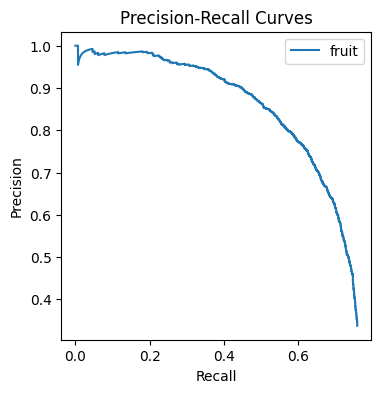

In [26]:
# high thresholds - allowing fewer positive anchors
model_high_thresh = get_faster_rcnn_model(fg_thresh=0.9)
train_fasterrcnn(model_high_thresh, train_loader)
evaluate_fasterrcnn(model_high_thresh, val_dataset, val_loader)


The IoU threshold is used to determine if a predicted bounding box is a true positive or a false positive. It is the minimum overlap required between the predicted bounding box and the ground truth bounding box for it to be considered a true positive. A higher IoU threshold will result in fewer true positives and more false negatives, while a lower IoU threshold will result in more true positives and more false positives.

### Effect of image resolution on detection performance

/home/gaurav/miniconda3/envs/cv/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Epoch 1/5


Training:   0%|          | 0/150 [00:00<?, ?it/s]/tmp/ipykernel_9415/2903762583.py:38: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  boxes = torch.tensor(masks_to_boxes(np.array(mask[0])), dtype=torch.float32)
Training: 100%|██████████| 150/150 [00:36<00:00,  4.10it/s]


rpn_classification: 0.4927 | rpn_localization: 1.3021 | frcnn_classification: 0.3641 | frcnn_localization: 0.0260
Epoch 2/5


Training: 100%|██████████| 150/150 [00:35<00:00,  4.23it/s]


rpn_classification: 0.2143 | rpn_localization: 1.1084 | frcnn_classification: 0.4033 | frcnn_localization: 0.1137
Epoch 3/5


Training: 100%|██████████| 150/150 [00:35<00:00,  4.22it/s]


rpn_classification: 0.1678 | rpn_localization: 1.0398 | frcnn_classification: 0.3518 | frcnn_localization: 0.1718
Epoch 4/5


Training: 100%|██████████| 150/150 [00:35<00:00,  4.23it/s]


rpn_classification: 0.1538 | rpn_localization: 1.0083 | frcnn_classification: 0.3206 | frcnn_localization: 0.1641
Epoch 5/5


Training: 100%|██████████| 150/150 [00:35<00:00,  4.20it/s]


rpn_classification: 0.1390 | rpn_localization: 0.9879 | frcnn_classification: 0.3139 | frcnn_localization: 0.1498
Training complete.


100%|██████████| 69/69 [00:02<00:00, 28.39it/s]


mAP at IoU threshold 0.5: 0.2095319047389483
mAP at IoU threshold 0.7: 0.045454545454545456
mAP at IoU threshold 0.9: 0.0007704160246533128
False Positives per class: {'fruit': 5980}
False Negatives per class: {'fruit': 1912}


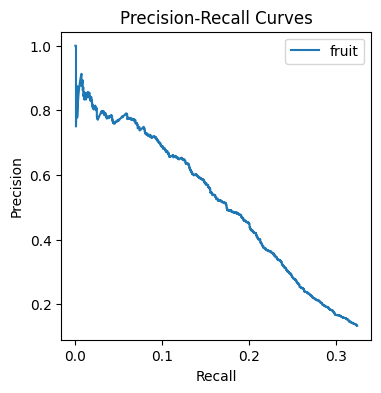

In [24]:
# get low resolution train images and masks
train_images_low_res = np.array([cv2.resize(img, (400, 400)) for img in train_images])
train_masks_low_res = np.array([cv2.resize(mask, (400, 400)) for mask in train_masks])
train_boxes_low_res = [masks_to_boxes(mask) for mask in train_masks_low_res]

train_dataset_low_res = FruitDetectionDataset(train_images_low_res, train_boxes_low_res, train_masks_low_res, transform=False)
train_loader_low_res = DataLoader(train_dataset_low_res, batch_size=4, shuffle=True, collate_fn=collate_function)
model_low_res = get_faster_rcnn_model()

train_fasterrcnn(model_low_res, train_loader_low_res)
evaluate_fasterrcnn(model_low_res, val_dataset, val_loader)

A lower resolution image will have fewer pixels and less detail, which can make it harder to detect small objects. Since most of the fruits in the dataset are very small, a lower resolution image may result in missed detections. On the other hand, a higher resolution image will have more pixels and more detail, which can help in detecting small objects more accurately. However, a higher resolution image will also require more computational resources and may slow down the detection process.

## Analysis and Evaluation


- **Impact of occlusion on detection performance**: Occlusion can affect the detection performance as it can hide parts of the object and make it difficult for the model to detect the object. The model may not be able to detect the object if it is partially occluded.
- **Impact of lighting conditions on detection performance**: Lighting conditions can affect the detection performance as it can change the appearance of the object and make it difficult for the model to detect the object. The model may not be able to detect the object if the lighting conditions are poor. Attempting to augment the dataset with different lighting conditions can help improve the detection performance.
- **Densely clustered fruits**: Densely clustered fruits can affect the detection performance as the model may detect multiple fruits as a single fruit. The model may not be able to separate the individual fruits in a densely clustered scenario. Using a higher resolution image can help improve the detection performance in such scenarios.
- **Fruits at different scales**: Fruits at different scales can affect the detection performance as the model may not be able to detect small fruits or large fruits accurately. Using anchor boxes of different sizes and aspect ratios can help improve the detection performance for fruits at different scales.

## Generalization Analysis

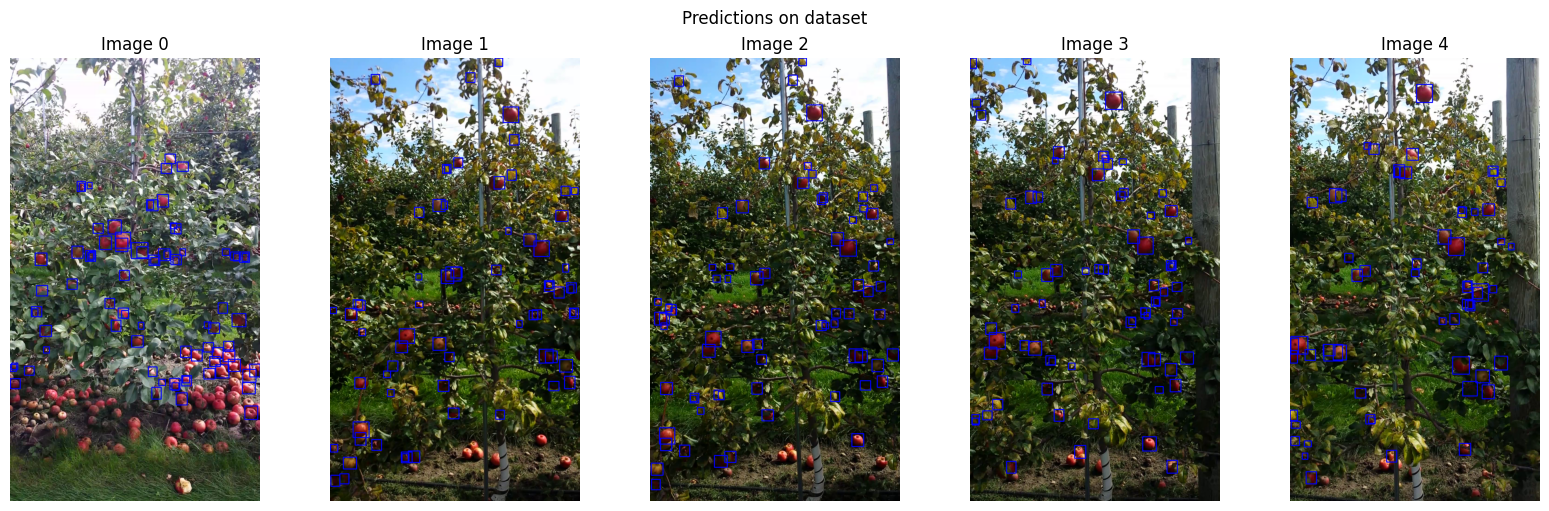

In [23]:
# results on test dataset
visualize_predictions(model, test_loader)

- **Different Fruit Types:** The model can be generalized to detect different types of fruits by training it on a diverse dataset containing different types of fruits. In the current dataset, fruits are too small and look similar, hence the model may not be able to generalize well to different types of fruits. Training the model on a multi class fruit dataset can help improve the generalization performance of the model to different types of fruits.

- **Different Backgrounds:** The current model is robust to different backgrounds as it has been trained on a dataset containing fruits with different natural backgrounds. However, the model may not be able to generalize well to fruits with artificial backgrounds or fruits in different environments. Training the model on a diverse dataset with fruits in different backgrounds can help improve the generalization performance of the model to different backgrounds. 

- **Different Lighting Conditions:** The current model is trained on a dataset in natural lighting conditions. It may not be able to generalize well to fruits in different lighting conditions. Data augmentation techniques such as changing the brightness, contrast, and saturation of the images can help improve the generalization performance of the model to different lighting conditions.

- **Handling Growth stages and ripeness:** The current model is not specifically trained to detect fruits at different growth stages or ripeness levels. A diverse dataset with fruits at different growth stages and ripeness levels with the models reliance on hue can help in detecting fruits at different growth stages and ripeness levels.